# Mean Variance Optimization

You're an investment analyst at a large fund. You specialize in calculating efficient frontiers and selecting assets for portfolios.

In this project, you will do the following:
1. Follow the steps to calculate the efficient frontier of a portfolio with five assets.
2. See how two additional assets affect the efficient frontier.
3. Use the covariance matrix and expected returns from ten assets to select the five assets that produce the best efficient frontier.

## Calculate the Efficient Frontier of a Portfolio

1. Load **stock_data_weak.csv** as a DataFrame and save it to a variable called `stock_data`.

   Use `print(stock_data)` to visualize the data.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the stock data.
stock_data = pd.read_csv('stock_data_weak.csv')
print(stock_data)

          Date  General Electric  Chesapeake Energy   AT&T  Cisco Systems  \
0   12/31/2007             37.08              39.36  42.12          27.25   
1    3/31/2008             36.63              45.76  37.71          24.08   
2    6/30/2008             26.35              66.77  32.75          23.47   
3    9/30/2008             23.87              33.29  28.35          22.25   
4   12/31/2008             15.82              15.34  28.19          16.18   
5    3/31/2009             10.33              17.65  25.44          16.53   
6    6/30/2009             11.84              19.72  25.14          18.94   
7    9/30/2009             16.83              28.80  27.34          23.55   
8   12/31/2009             15.27              26.36  28.29          24.10   
9    3/31/2010             18.21              23.52  25.90          26.52   
10   6/30/2010             14.47              21.47  24.35          21.52   
11   9/30/2010             16.46              22.66  28.78          22.05   

2. Find the quarterly returns over each period for all assets in `stock_data`. Save the result to `returns_quarterly`.

In [4]:
# 2. Find the quarterly return for each period
selected= list(stock_data.columns[1:])
returns_quarterly = stock_data[selected].pct_change()



3. Find the expected return for each asset and save the result to `expected_returns`.

In [5]:
# 3. Find the expected returns
expected_returns = returns_quarterly.mean()

4. Find the covariance of the quarterly returns over each period and save the result to `cov_quarterly`.

In [6]:
# 4. Find the covariance
cov_quarterly = returns_quarterly.cov()

5. We've provided the function `return_portfolios()` below. The function accepts the expected return and quarterly covariance of a set of asset and returns a random collection of 5,000 portfolios. The return is formatted as a DataFrame with columns: `'Volatility'` and `'Returns'`.

   Use the expected returns and covariances to find a set of random portfolios. Save the result to `random_portfolios`.

In [8]:
def return_portfolios(expected_returns, cov_matrix):
    port_returns = []
    port_volatility = []
    stock_weights = []
    
    selected = (expected_returns.axes)[0]
    
    num_assets = len(selected)
    num_portfolios = 5000
    
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, expected_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
        
    portfolio = {'Returns': port_returns, 'Volatility': port_volatility}
    
    for counter, symbol in enumerate(selected):
        portfolio[symbol + 'Weight'] = [Weight[counter] for Weight in stock_weights]
        
    df = pd.DataFrame(portfolio)
    
    column_order = ['Returns', 'Volatility'] + [stock+'Weight' for stock in selected]
    
    df = df[column_order]
    
    return df



In [6]:
# 5. Find a set of random portfolios
random_portfolios = return_portfolios(expected_returns, cov_quarterly)

6. Plot the random portfolios.

<AxesSubplot:xlabel='Volatility', ylabel='Returns'>

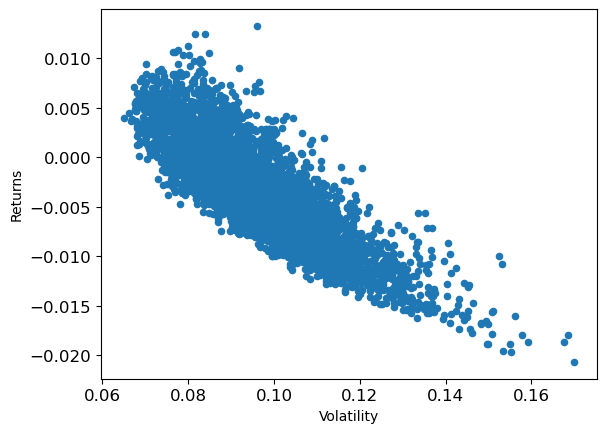

In [11]:
# 6. Plot the set of random porfolios
random_portfolios.plot.scatter(x='Volatility', y='Returns', fontsize=12)

7. We've provided the function `optimal_portfolio()` below. This function accepts the quarterly returns of a set of assets. The function returns the `weights`, `returns`, and `risks` of portfolios on the efficient frontiers. The returns are formatted as NumPy arrays.

   Use the `optimal_portfolio()` function to calculate the `weights`, `returns`, and `risks` of portfolios on the efficient frontier.

In [25]:
import cvxopt as opt
from cvxopt import blas, solvers

def optimal_portfolio(returns):
    n = returns.shape[1]
    returns = np.transpose(returns.values)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n)) # negative n x n identity matrix
    h = opt.matrix(0.0, (n,1))
    A = opt.matrix(1.0, (1,n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

**if you don't have cvxopt installed, uncomment the next cell.** The % is a way to create a cell that behaves like a teminal.

In [24]:
%pip install cvxopt


^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [27]:
# 7. Calculate the set of portfolios on the EF
weights, returns, risks = optimal_portfolio(returns_quarterly[1:])

     pcost       dcost       gap    pres   dres
 0:  2.3517e-03 -1.0183e+00  1e+00  1e-16  3e+00
 1:  1.8118e-03 -2.8254e-02  3e-02  8e-17  8e-02
 2: -1.4950e-02 -1.9458e-02  5e-03  1e-16  1e-17
 3: -1.7780e-02 -1.7871e-02  9e-05  2e-16  2e-17
 4: -1.7834e-02 -1.7835e-02  9e-07  1e-16  1e-17
 5: -1.7835e-02 -1.7835e-02  9e-09  4e-16  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.3950e-03 -1.0182e+00  1e+00  3e-16  3e+00
 1:  1.8529e-03 -2.8227e-02  3e-02  8e-17  8e-02
 2: -1.4853e-02 -1.9394e-02  5e-03  2e-16  2e-17
 3: -1.7699e-02 -1.7791e-02  9e-05  3e-16  8e-18
 4: -1.7756e-02 -1.7757e-02  9e-07  2e-16  1e-17
 5: -1.7756e-02 -1.7756e-02  9e-09  2e-16  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.4435e-03 -1.0182e+00  1e+00  2e-16  3e+00
 1:  1.8989e-03 -2.8196e-02  3e-02  4e-17  8e-02
 2: -1.4745e-02 -1.9323e-02  5e-03  2e-16  2e-17
 3: -1.7609e-02 -1.7701e-02  9e-05  2e-16  1e-17
 4: -1.7667e-02 -1.7668e

8. Plot the efficient frontier as a yellow line with dots on the plot.

   Use the following code to set the x-label, y-label, and title:
   
   ```py
   plt.ylabel('Expected Returns', fontsize=14)
   plt.xlabel('Volatility (Std. Deviation)', fontzie=14)
   plt.title('Efficient Frontier', fontsize=24)
   ```

Text(0.5, 1.0, 'Efficient Frontier')

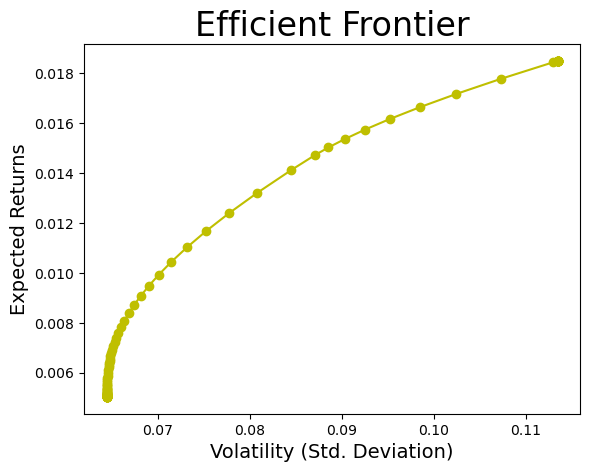

In [28]:
# 8. Plot the set of portfolios on the EF
plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)

## How Do Two Additional Assets Affect the EF?

9. You inherited a portfolio with five assets, stored in **stock_data_weak.csv**:

   Asset | Expected Return
   --- | ---
   General Electric | -0.0120
   Chesapeake Energy | -0.0306
   AT&T | -0.0014
   Cisco Systems | 0.0184
   Campbell Soup | 0.0084

   View the output below, which visualizes the efficient frontier for these asstes.

     pcost       dcost       gap    pres   dres
 0: -1.0662e-02 -1.0359e+00  1e+00  0e+00  3e+00
 1: -1.1534e-02 -4.5915e-02  3e-02  1e-16  1e-01
 2: -3.2498e-02 -3.8737e-02  6e-03  1e-16  2e-03
 3: -3.4247e-02 -3.4697e-02  4e-04  3e-17  1e-04
 4: -3.4442e-02 -3.4469e-02  3e-05  1e-16  5e-07
 5: -3.4446e-02 -3.4446e-02  4e-07  2e-16  5e-09
 6: -3.4446e-02 -3.4446e-02  4e-09  2e-16  5e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0582e-02 -1.0358e+00  1e+00  1e-16  3e+00
 1: -1.1451e-02 -4.5792e-02  3e-02  7e-17  1e-01
 2: -3.2227e-02 -3.8492e-02  6e-03  2e-16  2e-03
 3: -3.4012e-02 -3.4437e-02  4e-04  9e-18  8e-05
 4: -3.4193e-02 -3.4213e-02  2e-05  2e-16  7e-07
 5: -3.4196e-02 -3.4196e-02  2e-07  1e-16  7e-09
 6: -3.4196e-02 -3.4196e-02  2e-09  2e-16  7e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0492e-02 -1.0357e+00  1e+00  0e+00  3e+00
 1: -1.1358e-02 -4.5653e-02  3e-02  9e-17  1e-01
 2: -3.1924e-02 -3.8217e

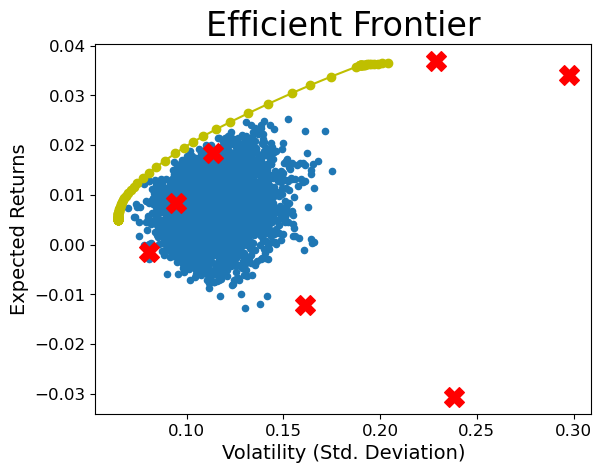

In [30]:
path = 'stock_data2.csv'

# Load the stock data
stock_data = pd.read_csv(path)

# Find the quarterly for each period
selected = list(stock_data.columns[1:])
returns_quarterly = stock_data[selected].pct_change()

# Find the expected returns
expected_returns = returns_quarterly.mean()

# Find the covariance
cov_quarterly = returns_quarterly.cov()

# Find a set of random portfolios
random_portfolios = return_portfolios(expected_returns, cov_quarterly)

# Plot the set of random portfolios
random_portfolios.plot.scatter(x='Volatility', y='Returns', fontsize=12)

# Calculate the set of portfolios on the EF
weights, returns, risks = optimal_portfolio(returns_quarterly[1:])

# Plot the set of portfolios on the EF
plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)

# Compare the set of portfolios on the EF
single_asset_std=np.sqrt(np.diagonal(cov_quarterly))
plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)

plt.show()

10. You decide to diversify the portfolio with a couple of assets to increase the expected return of portfolios on the efficient frontier.

    You choose to add Bank of America and Marvel, so your assets are:
    
    Asset | Expected Return
    --- | ---
    General Electric | -0.0120
    Chesapeake Energy | -0.0306
    AT&T | -0.0014
    Cisco Systems | 0.0184
    Campbell Soup | 0.0084
    Bank of America | 0.0341
    Marvel | 0.0369
    
    Change the `path` variable to **stock_data2.csv** to visualize this new efficient frontier.

     pcost       dcost       gap    pres   dres
 0: -1.0662e-02 -1.0359e+00  1e+00  0e+00  3e+00
 1: -1.1534e-02 -4.5915e-02  3e-02  1e-16  1e-01
 2: -3.2498e-02 -3.8737e-02  6e-03  1e-16  2e-03
 3: -3.4247e-02 -3.4697e-02  4e-04  3e-17  1e-04
 4: -3.4442e-02 -3.4469e-02  3e-05  1e-16  5e-07
 5: -3.4446e-02 -3.4446e-02  4e-07  2e-16  5e-09
 6: -3.4446e-02 -3.4446e-02  4e-09  2e-16  5e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0582e-02 -1.0358e+00  1e+00  1e-16  3e+00
 1: -1.1451e-02 -4.5792e-02  3e-02  7e-17  1e-01
 2: -3.2227e-02 -3.8492e-02  6e-03  2e-16  2e-03
 3: -3.4012e-02 -3.4437e-02  4e-04  9e-18  8e-05
 4: -3.4193e-02 -3.4213e-02  2e-05  2e-16  7e-07
 5: -3.4196e-02 -3.4196e-02  2e-07  1e-16  7e-09
 6: -3.4196e-02 -3.4196e-02  2e-09  2e-16  7e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0492e-02 -1.0357e+00  1e+00  0e+00  3e+00
 1: -1.1358e-02 -4.5653e-02  3e-02  9e-17  1e-01
 2: -3.1924e-02 -3.8217e

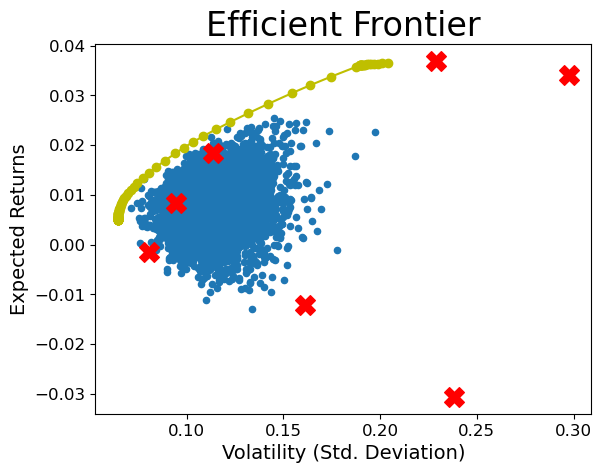

In [31]:
# 10. Change the path variable.
path = 'stock_data2.csv'

# Load the stock data
stock_data = pd.read_csv(path)

# Find the quarterly for each period
selected = list(stock_data.columns[1:])
returns_quarterly = stock_data[selected].pct_change()

# Find the expected returns
expected_returns = returns_quarterly.mean()

# Find the covariance
cov_quarterly = returns_quarterly.cov()

# Find a set of random portfolios
random_portfolios = return_portfolios(expected_returns, cov_quarterly)

# Plot the set of random portfolios
random_portfolios.plot.scatter(x='Volatility', y='Returns', fontsize=12)

# Calculate the set of portfolios on the EF
weights, returns, risks = optimal_portfolio(returns_quarterly[1:])

# Plot the set of portfolios on the EF
plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)

# Compare the set of portfolios on the EF
single_asset_std=np.sqrt(np.diagonal(cov_quarterly))
plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)

plt.show()

11. It's hard to visualize how much the efficient frontier improved with these assets. Let's plot the original frontier on the same figure. Use the following code to do this:

    ```py
    weak_EF = pd.read_csv('weak_risks_returns.csv')
    plt.plot(weak_EF['Risks'], weak_EF['Returns'], 'g-o')
    ```
    
    To get a better view of the efficient frontier, you may want to comment out the following line:
    
    ```py
    random_portfolios.plot.scatter(x='Volatility', y='Returns', fontsize=12)
    ```
    
    By adding the two high-return assets, we increased the expected return of portfolios on the efficient frontier.

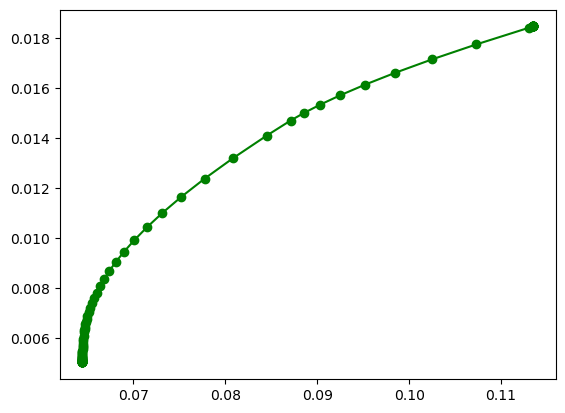

In [32]:
# 11. Compare to original
weak_EF = pd.read_csv('weak_risks_returns.csv')
plt.plot(weak_EF['Risks'], weak_EF['Returns'], 'g-o')

12. If you look at the expected returns of assets in your portfolio, you'll notice that General Electric and Chesapeake Energy have a large negative return (i.e. you expect to lose money).

    Asset | Expected Return
    --- | ---
    General Electric | -0.0120
    Chesapeake Energy | -0.0306
    AT&T | -0.0014
    Cisco Systems | 0.0184
    Campbell Soup | 0.0084
    Bank of America | 0.0341
    Marvel | 0.0369
    
    This begs the question: do we need these assets in our portfolio? Given their poor expected return, we should only keep them if they are uniquely uncorrelated to the rest of the assets in the portfolio.
    
    To check the effects of these assets, we calculated the efficient frontier for a portfolio **without** General Electric and Chesapeake Energy. Add the following code to the code block below to visualize this efficient frontier on the same plot.
    
    ```py
    strong_EF = pd.read_csv('strong_risks_returns.csv')
    plt.plot(strong_EF['Risks'], strong_EF['Returns'], 'k-x')
    ```
    
    What do you notice when you run the code?

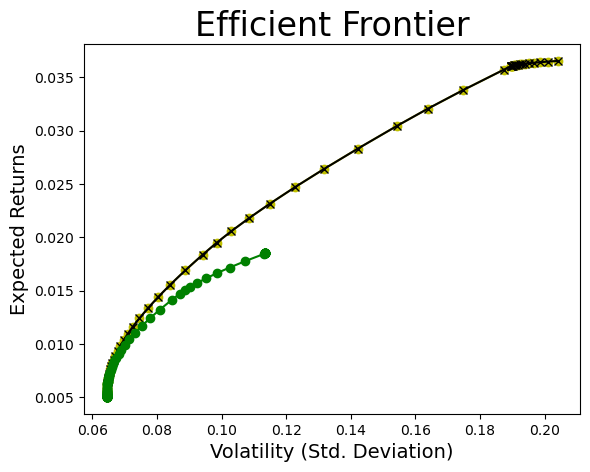

In [34]:
# 12. Plot Efficient Frontier Without Two Assets
plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)
weak_EF = pd.read_csv('weak_risks_returns.csv')
strong_EF = pd.read_csv('strong_risks_returns.csv')
plt.plot(strong_EF['Risks'], strong_EF['Returns'], 'k-x')
plt.plot(weak_EF['Risks'], weak_EF['Returns'], 'g-o')


## Finding the Best Efficient Frontier

13. Next, you will use your understanding of expected returns and covariances to inform portfolio decisions. We have asset data for 10 stocks, stored in **stock_data3.csv**.

    View the output from the code block below.
    
    You should see two efficient frontiers. We calculate the better efficient frontier (green dots) using all ten assets. We calculate the other efficient frontier using only five assets from the portfolio.
    
    Your job is to choose five assets from the following list to create the best efficient frontier.
    
    ```
    ['PFE', 'TGT', 'M', 'VZ', 'JPM', 'MRO', 'KO', 'PG', 'CVS', 'HPQ']
    ```
    
    Use the expected returns and covariance table, and set the `selected` variable equal to a list with five of these assets.

PFE    0.015530
TGT    0.014783
M      0.021962
VZ     0.004856
JPM    0.034781
MRO   -0.008010
KO    -0.002050
PG     0.004132
CVS    0.016124
HPQ   -0.000237
dtype: float64
          PFE       TGT         M        VZ       JPM       MRO        KO  \
PFE  0.010005  0.001738  0.005978  0.004071  0.007016  0.009721  0.002086   
TGT  0.001738  0.012874  0.015762  0.002188  0.007805  0.002239  0.002534   
M    0.005978  0.015762  0.038909  0.002804  0.016439  0.015110  0.005189   
VZ   0.004071  0.002188  0.002804  0.006958 -0.000407  0.005276  0.002586   
JPM  0.007016  0.007805  0.016439 -0.000407  0.023837  0.013848  0.002979   
MRO  0.009721  0.002239  0.015110  0.005276  0.013848  0.043166 -0.001516   
KO   0.002086  0.002534  0.005189  0.002586  0.002979 -0.001516  0.011021   
PG   0.004297  0.003148  0.005853  0.002094  0.006364  0.002834  0.001255   
CVS  0.004300  0.005384  0.012501  0.002052  0.005041  0.003689  0.003223   
HPQ  0.006996  0.007774  0.018937  0.003076  0.011523  

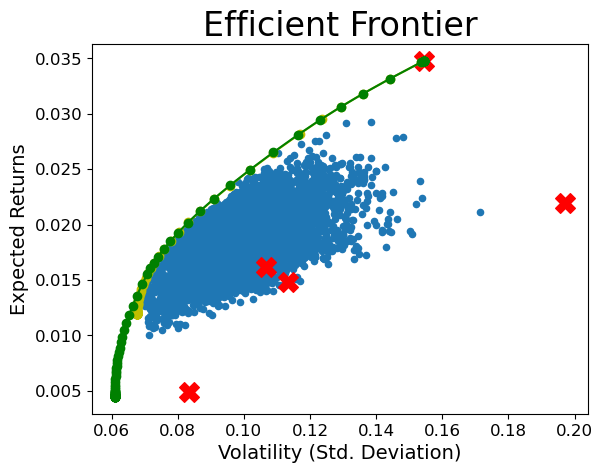

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

path='stock_data3.csv'

# 1. Load the stock data
stock_data = pd.read_csv(path)
selected = list(stock_data.columns[1:])
print(stock_data[selected].pct_change().mean())
print(stock_data[selected].pct_change().cov())

#stock_names = ['PFE', 'TGT', 'M', 'VZ', 'JPM', 'MRO', 'KO', 'PG', 'CVS', 'HPQ']
selected = ['TGT', 'CVS', 'M', 'VZ', 'JPM']

# 2. Find the quarterly for each period
returns_quarterly = stock_data[selected].pct_change()

# 3. Find the expected returns 
expected_returns = returns_quarterly.mean()

# 4. Find the covariance 
cov_quarterly = returns_quarterly.cov()

# 5. Find a set of random portfolios
random_portfolios = return_portfolios(expected_returns, cov_quarterly) 

# 6. Plot the set of random portfolios
random_portfolios.plot.scatter(x='Volatility', y='Returns', fontsize=12)

# 7. Calculate the set of portfolios on the EF
weights, returns, risks = optimal_portfolio(returns_quarterly[1:])

# 8. Plot the set of portfolios on the EF
plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)

#pd.DataFrame({'Risks': risks, 'Returns': returns}).to_csv('all_ten.csv', index=False)

# 9. Compare the set of portfolios on the EF
single_asset_std=np.sqrt(np.diagonal(cov_quarterly))
plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)

# All 10
all_ten_EF = pd.read_csv('all_ten.csv')
plt.plot(all_ten_EF['Risks'], all_ten_EF['Returns'], 'g-o')
plt.show()